In [1]:
from jcm.model import SpeedyModel
import jax

jax.config.update('jax_disable_jit', False) # Turn off JIT because of an issue in shortwave_radiation.py:169
jax.config.update("jax_debug_infs", True) # doesn't add any time since the saved time is otherwise spent getting the nodal quantities
jax.config.update("jax_debug_nans", False) # some physics fields might be nan


In [2]:
from jcm.held_suarez_physics import HeldSuarezPhysics

model = SpeedyModel(
    time_step=30,
    total_time=36,
    save_interval=3,
    # physics=HeldSuarezPhysics(),
)

In [3]:
# model = SpeedyModel(time_step=30, save_interval=3, total_time=36, layers=8) # takes 40 seconds on laptop gpu
state = model.get_initial_state()
final_state, predictions = model.unroll(state)

In [5]:
pred_ds = model.predictions_to_xarray(predictions)

In [6]:
print(f"dataset size: {pred_ds.nbytes/1e6:.1f}MB")

dataset size: 47.6MB


In [7]:
pred_ds.coords

Coordinates:
  * lon      (lon) float64 768B 0.0 3.75 7.5 11.25 ... 345.0 348.8 352.5 356.2
  * lat      (lat) float64 384B -87.16 -83.48 -79.78 ... 79.78 83.48 87.16
  * level    (level) float32 32B 0.95 0.835 0.685 0.51 0.34 0.2 0.095 0.025
  * time     (time) datetime64[ns] 96B 2000-01-01 2000-01-04 ... 2000-02-03

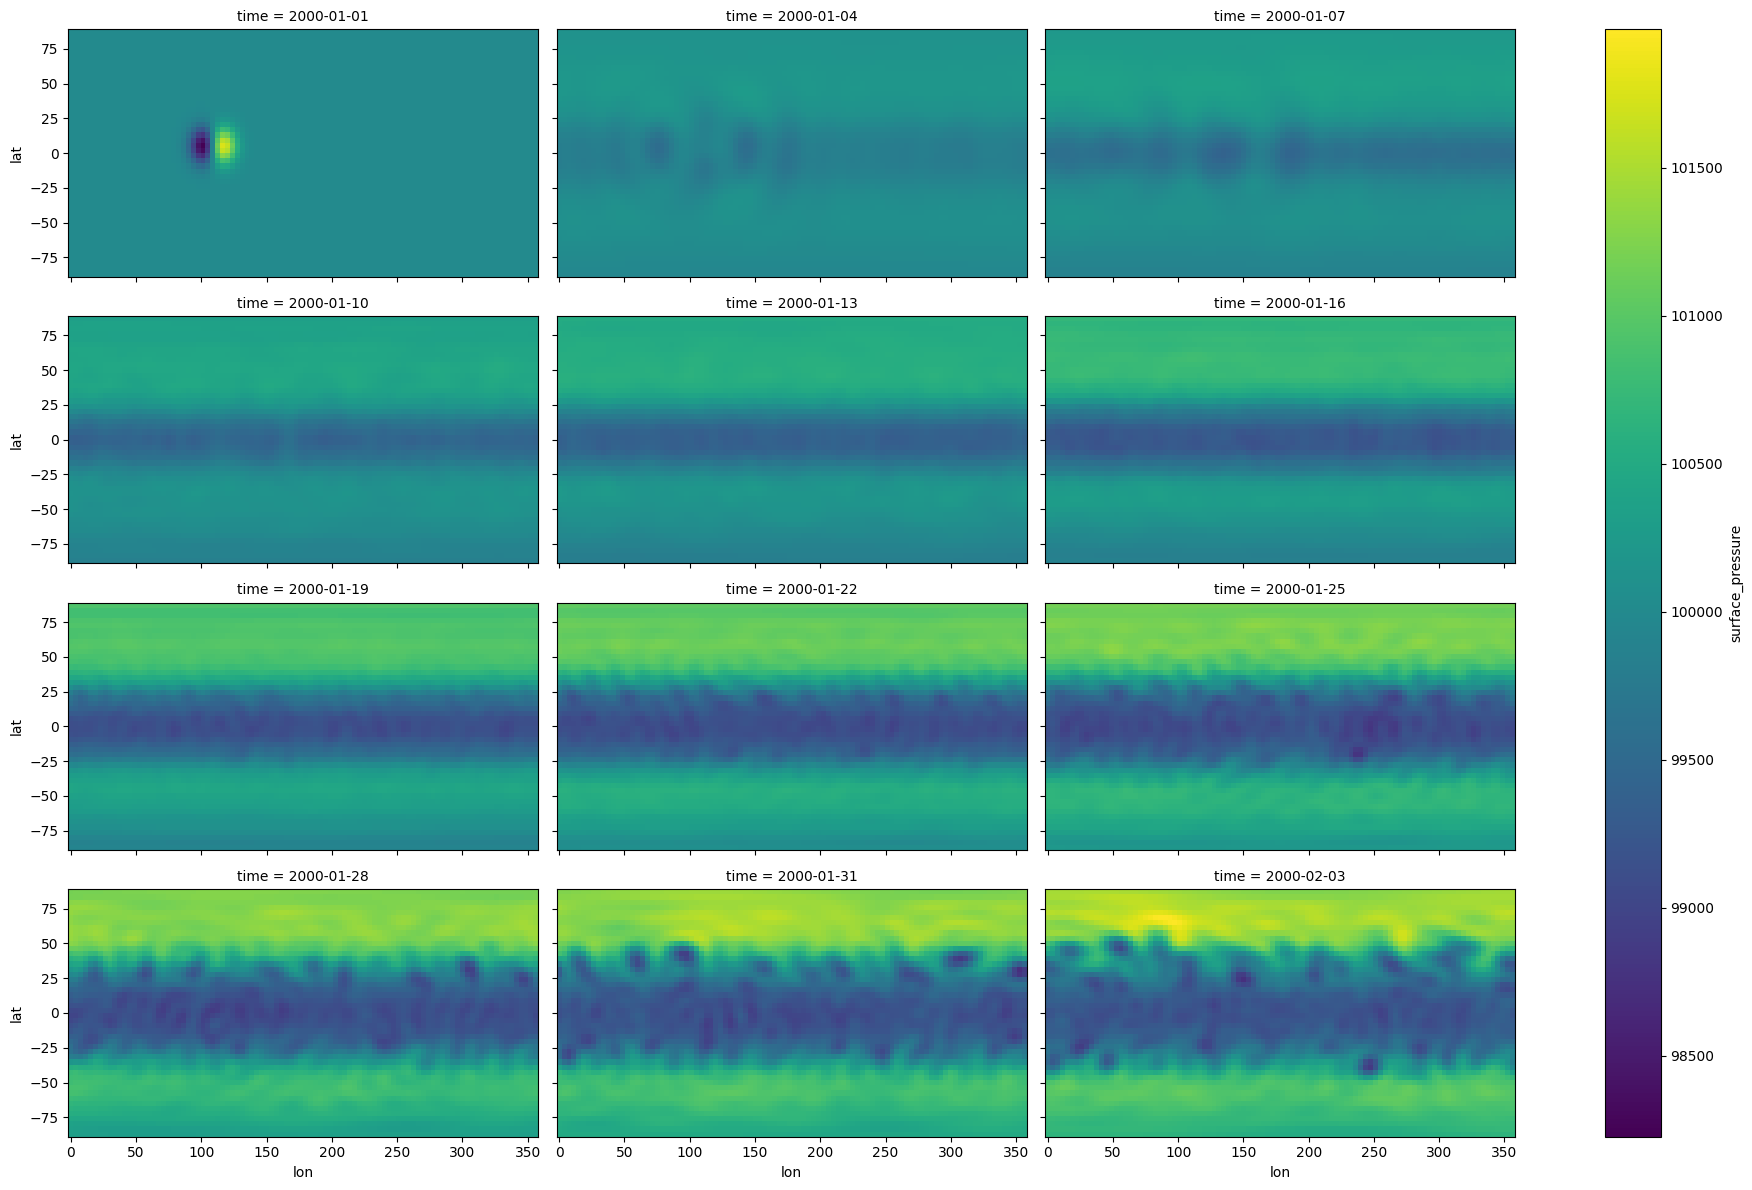

In [8]:
pred_ds['surface_pressure'].plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2);

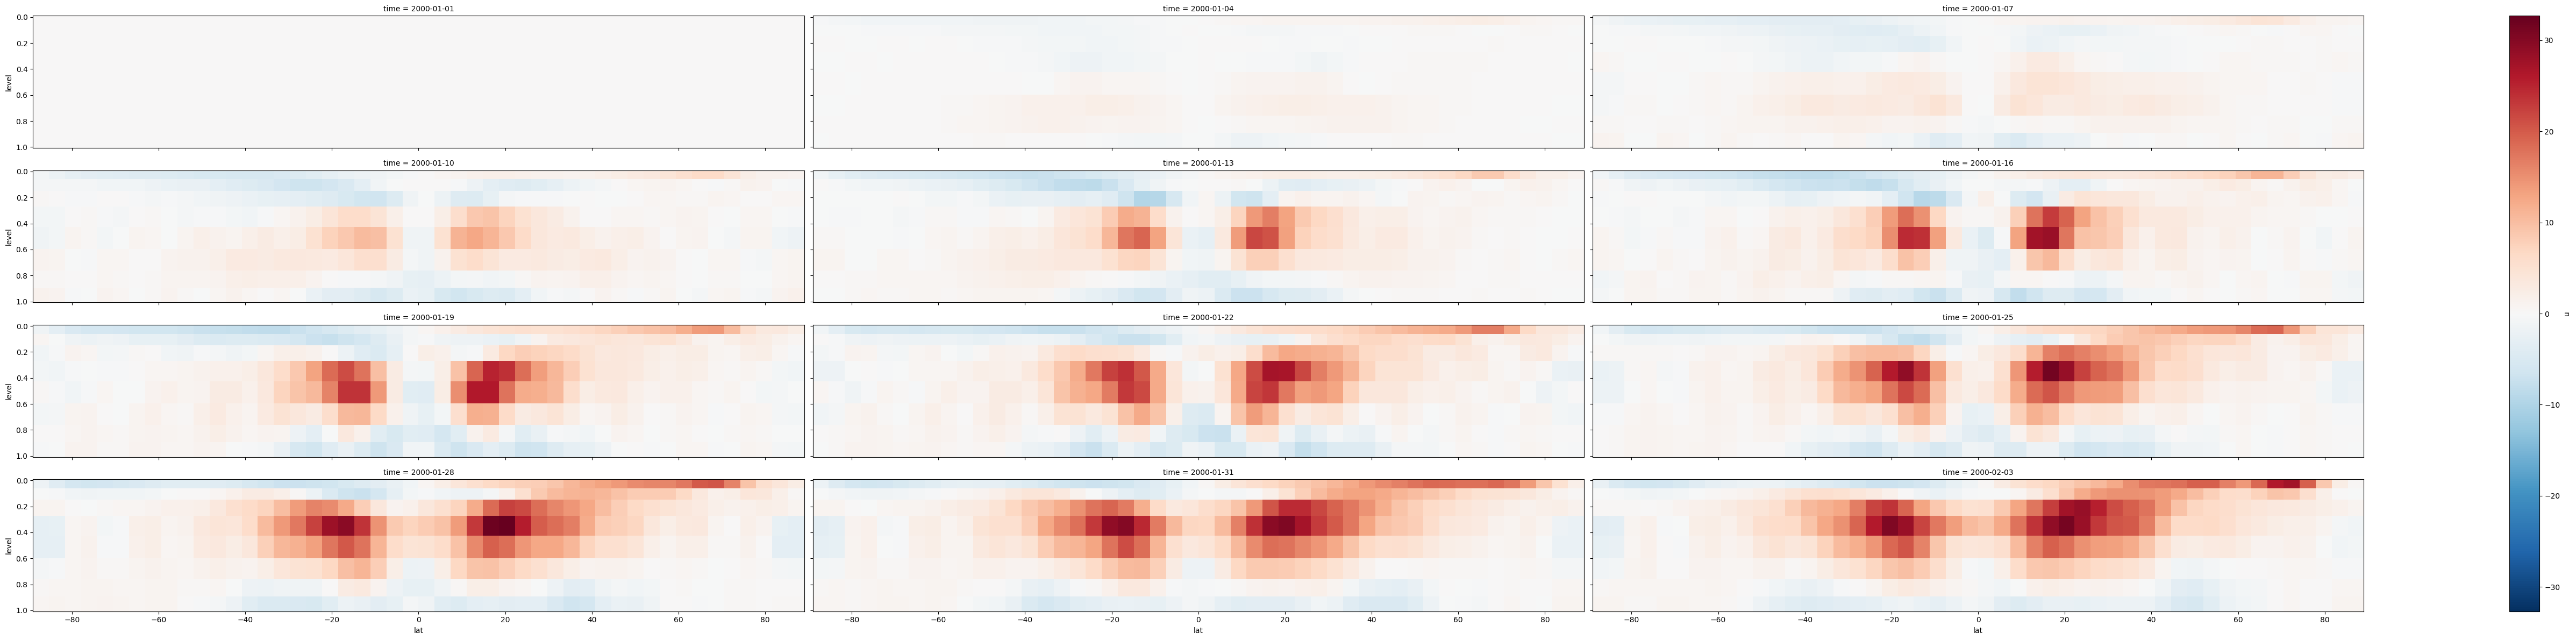

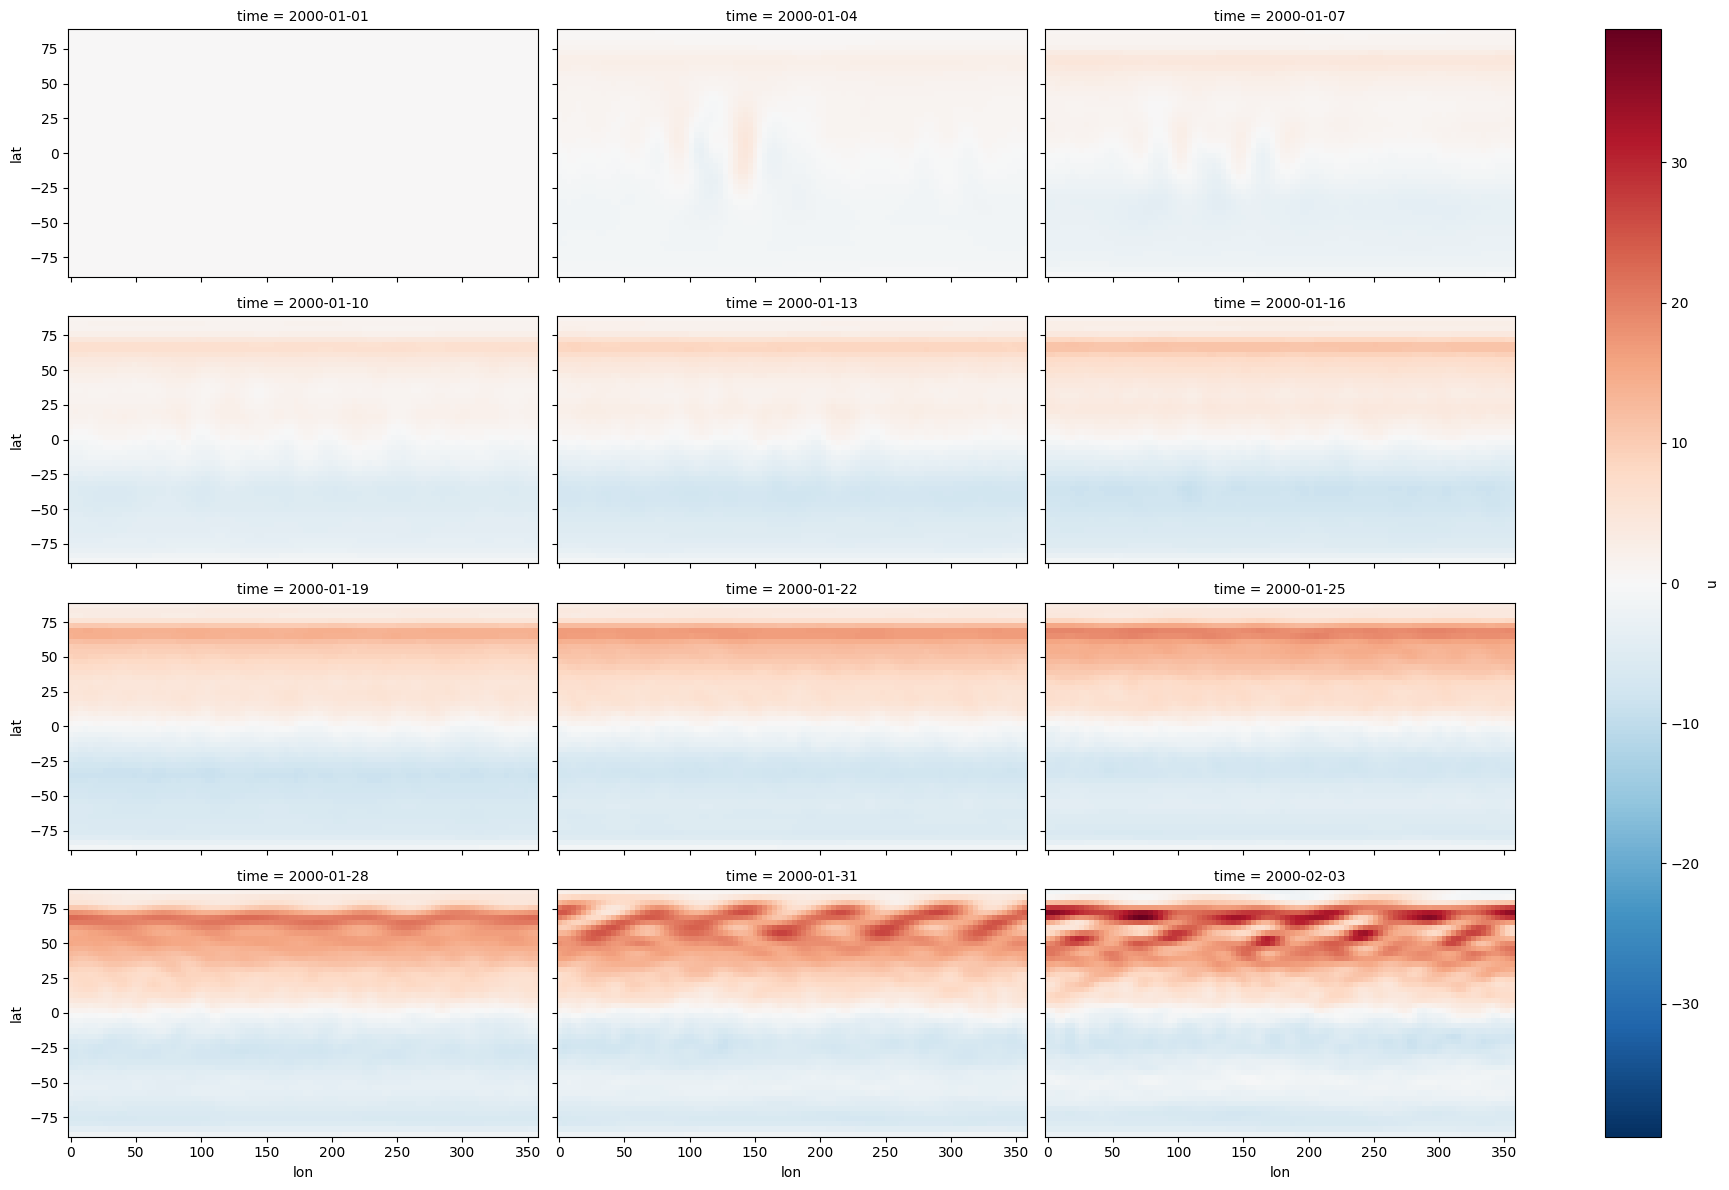

In [9]:
pred_ds['u'].mean('lon').plot(x='lat', y='level', col='time', col_wrap=3, aspect=6, yincrease=False);
pred_ds['u'].isel(level=-1).plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2);

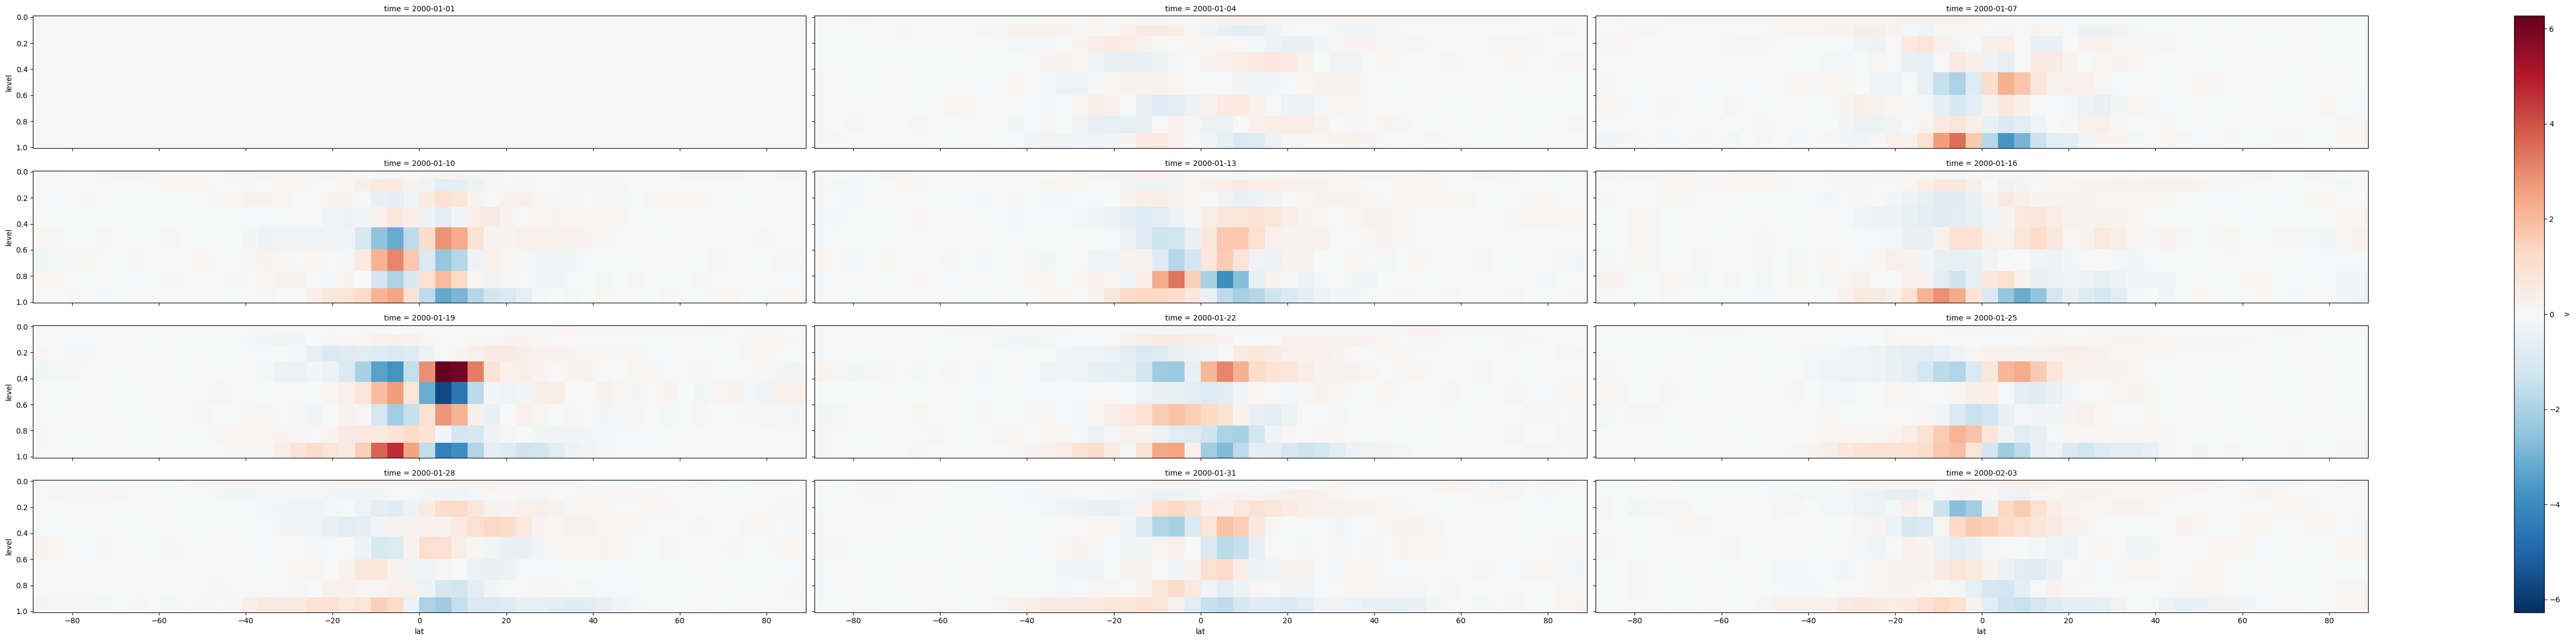

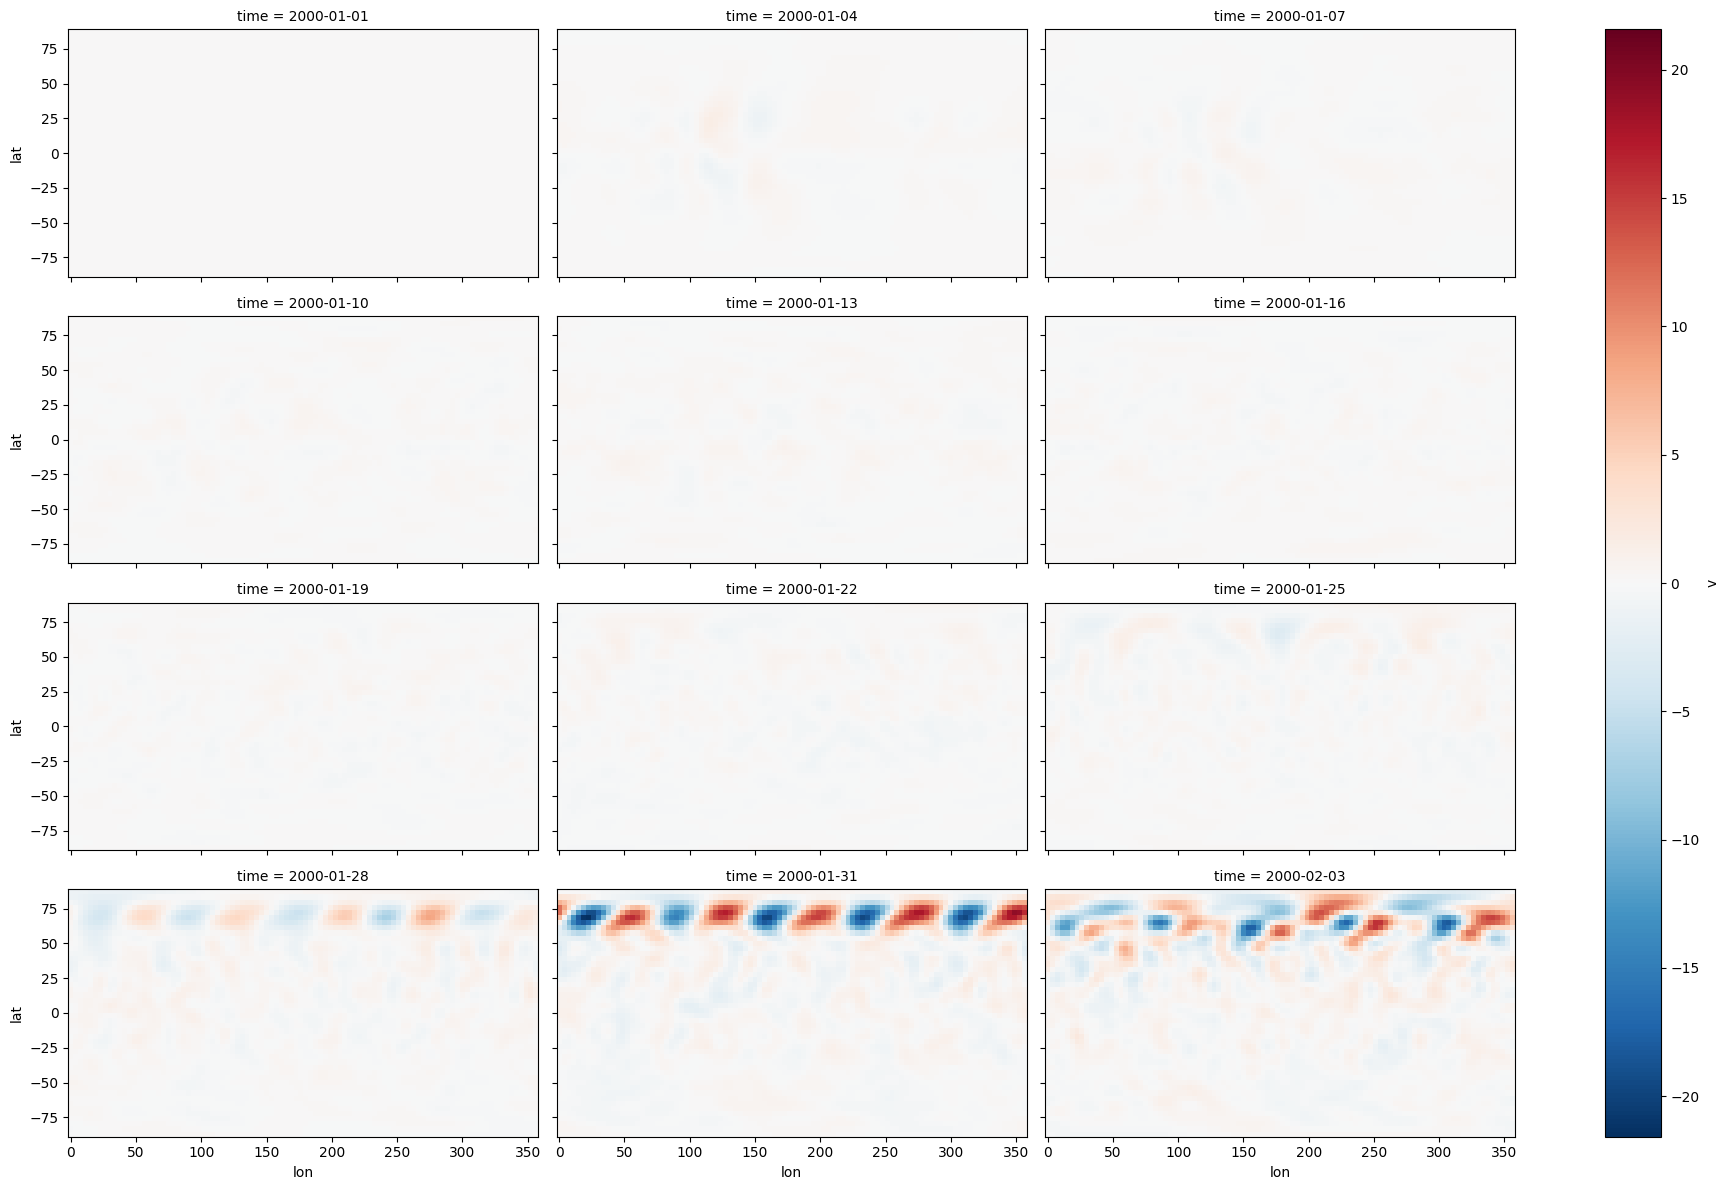

In [10]:
pred_ds['v'].mean('lon').plot(x='lat', y='level', col='time', col_wrap=3, aspect=6, yincrease=False);
pred_ds['v'].isel(level=-1).plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2);

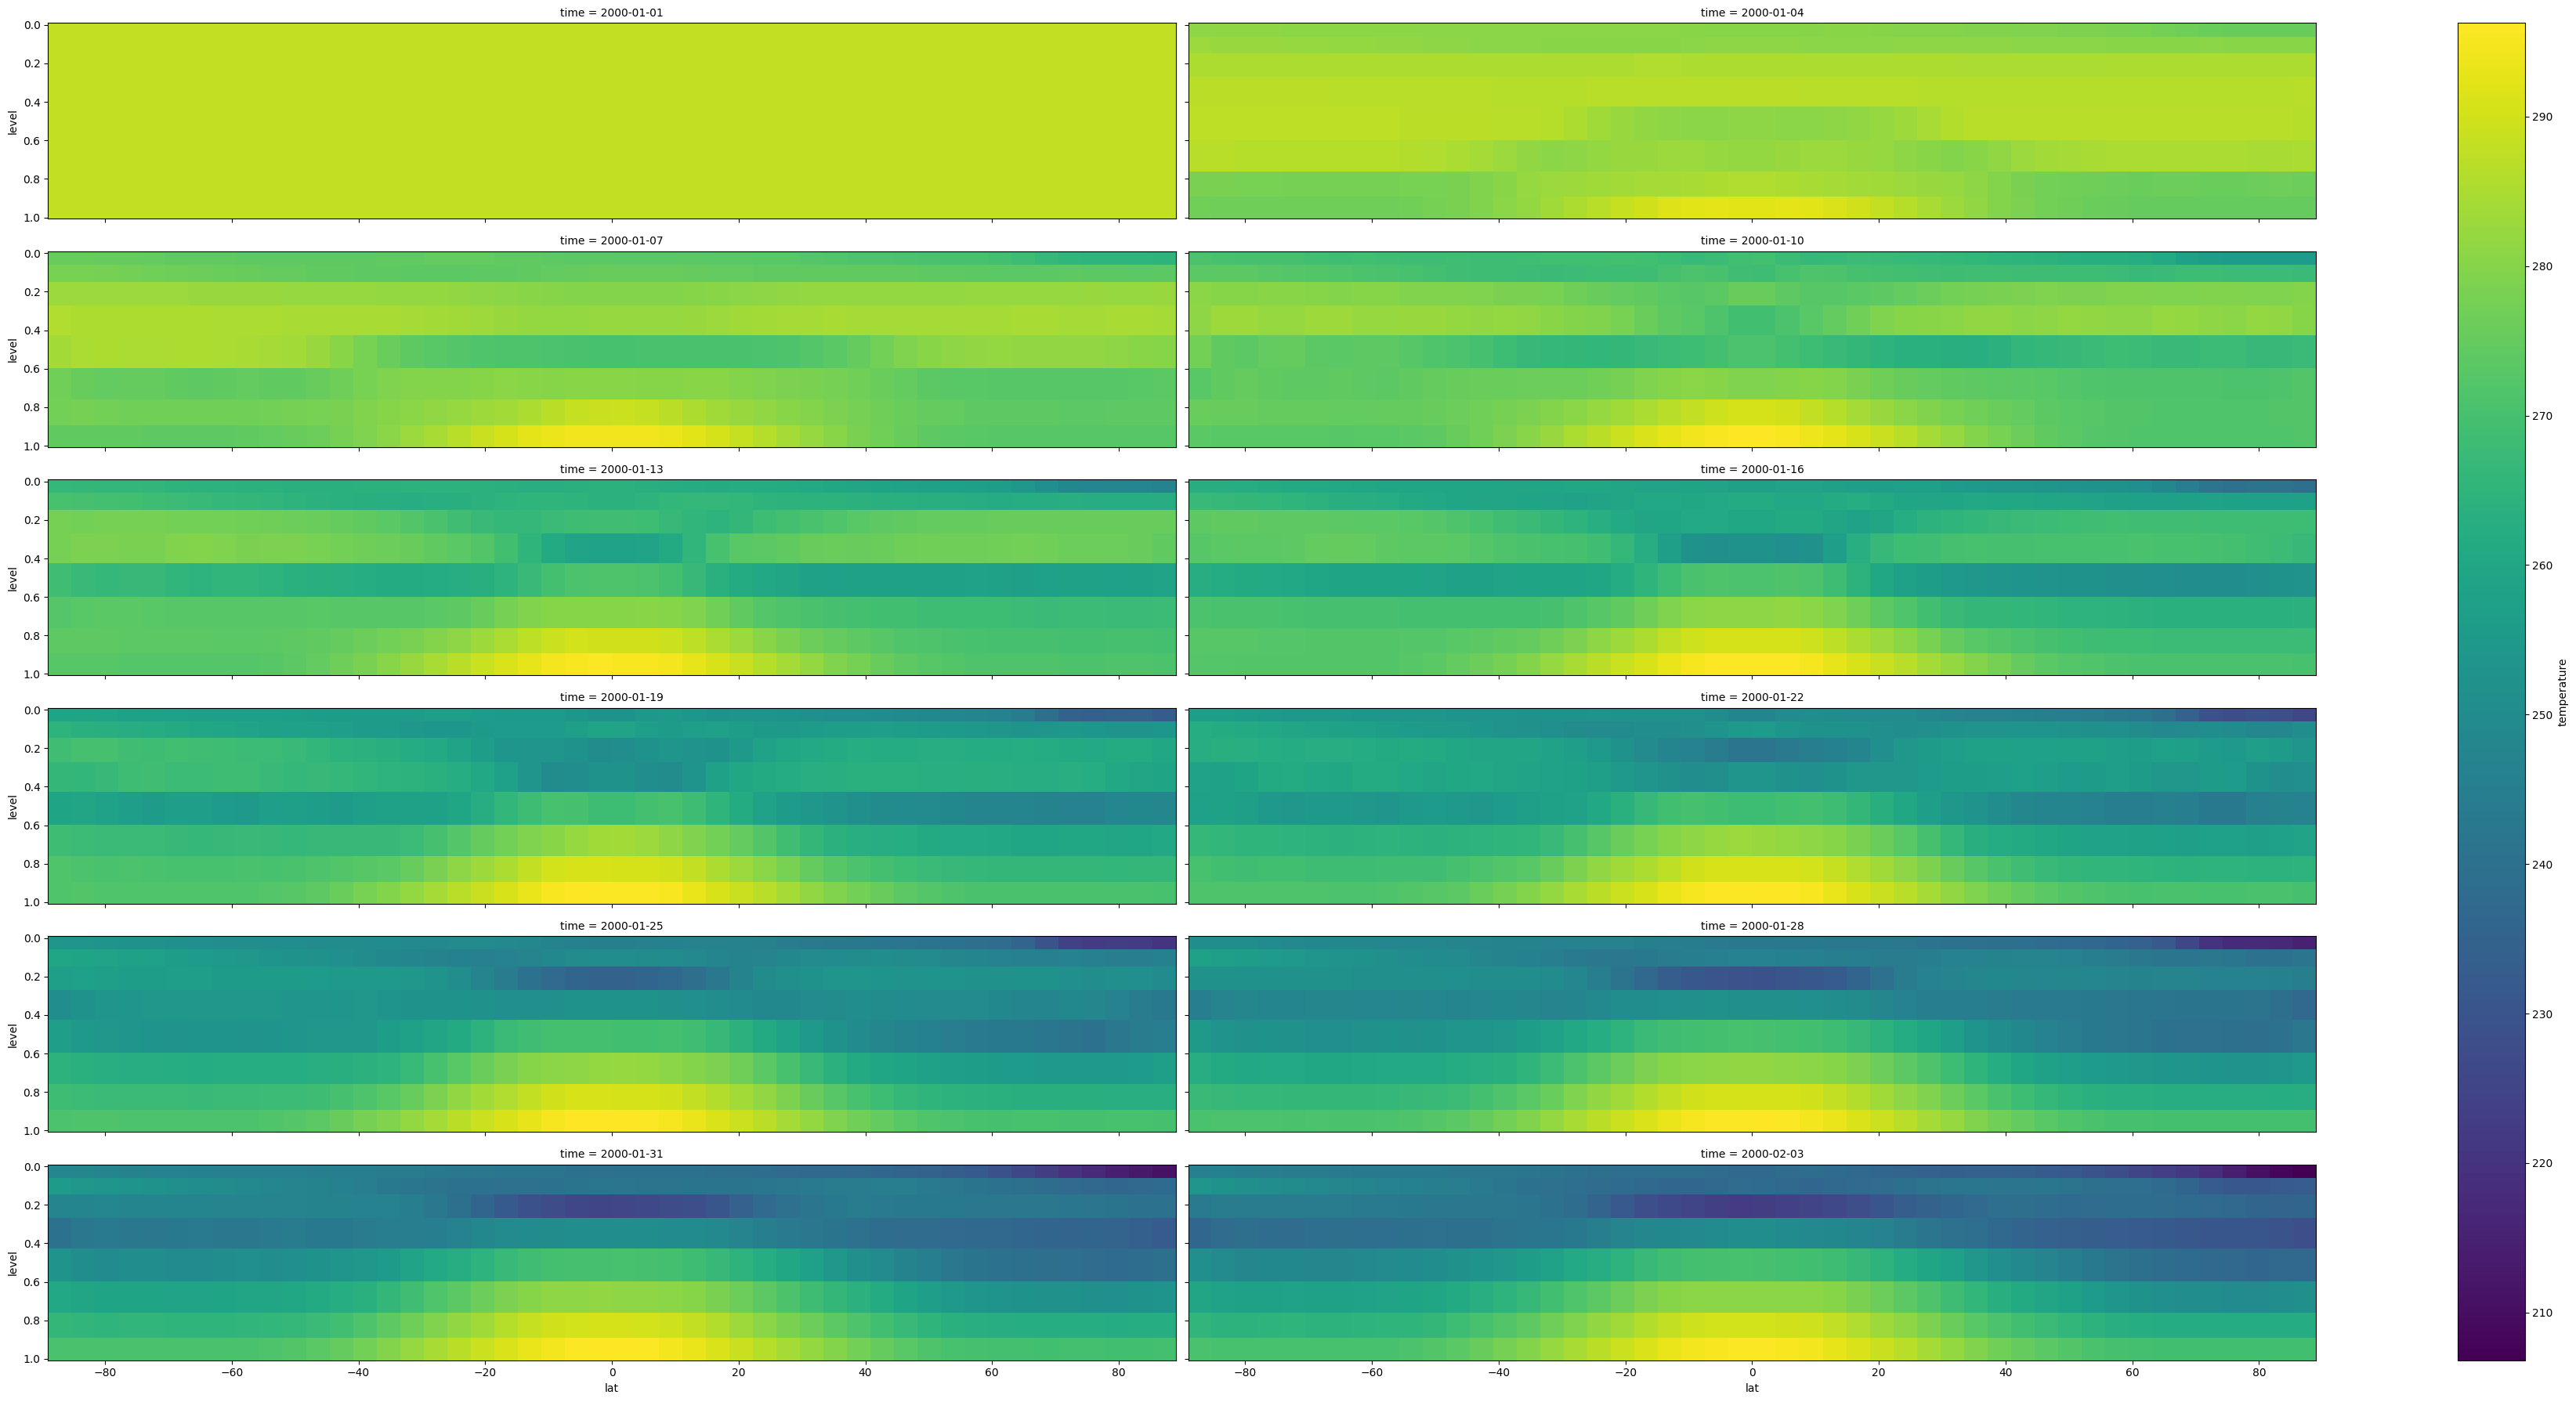

In [11]:
pred_ds['temperature'].mean('lon').plot(x='lat', y='level', col='time', col_wrap=2, aspect=6, yincrease=False);

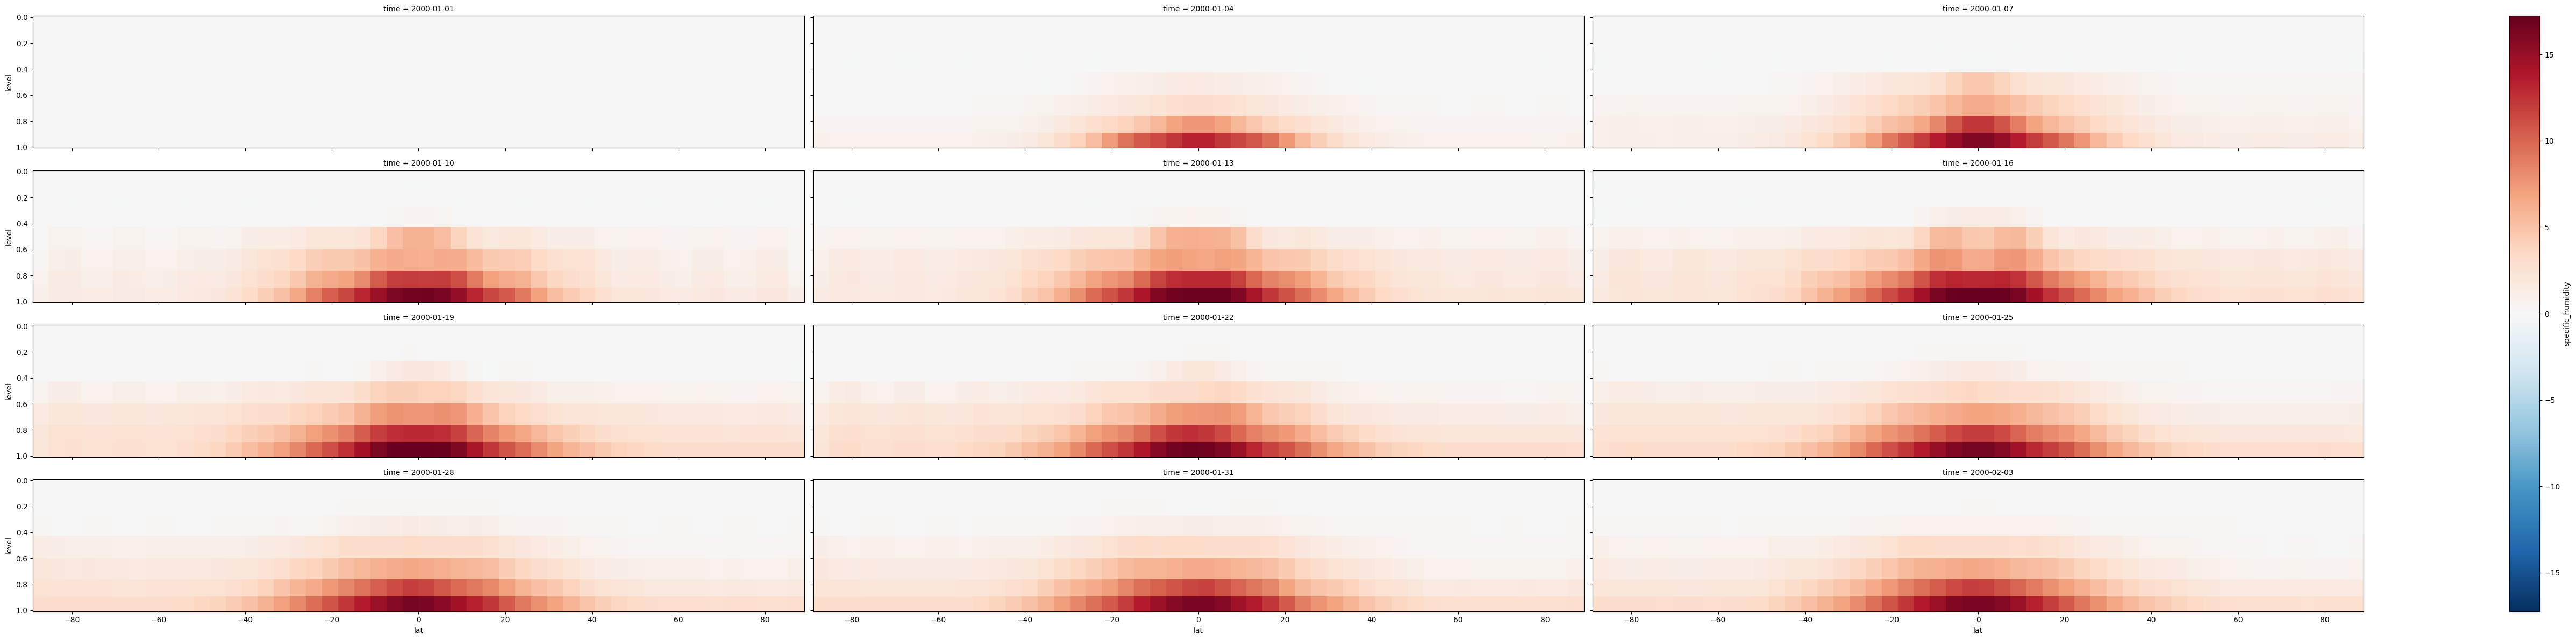

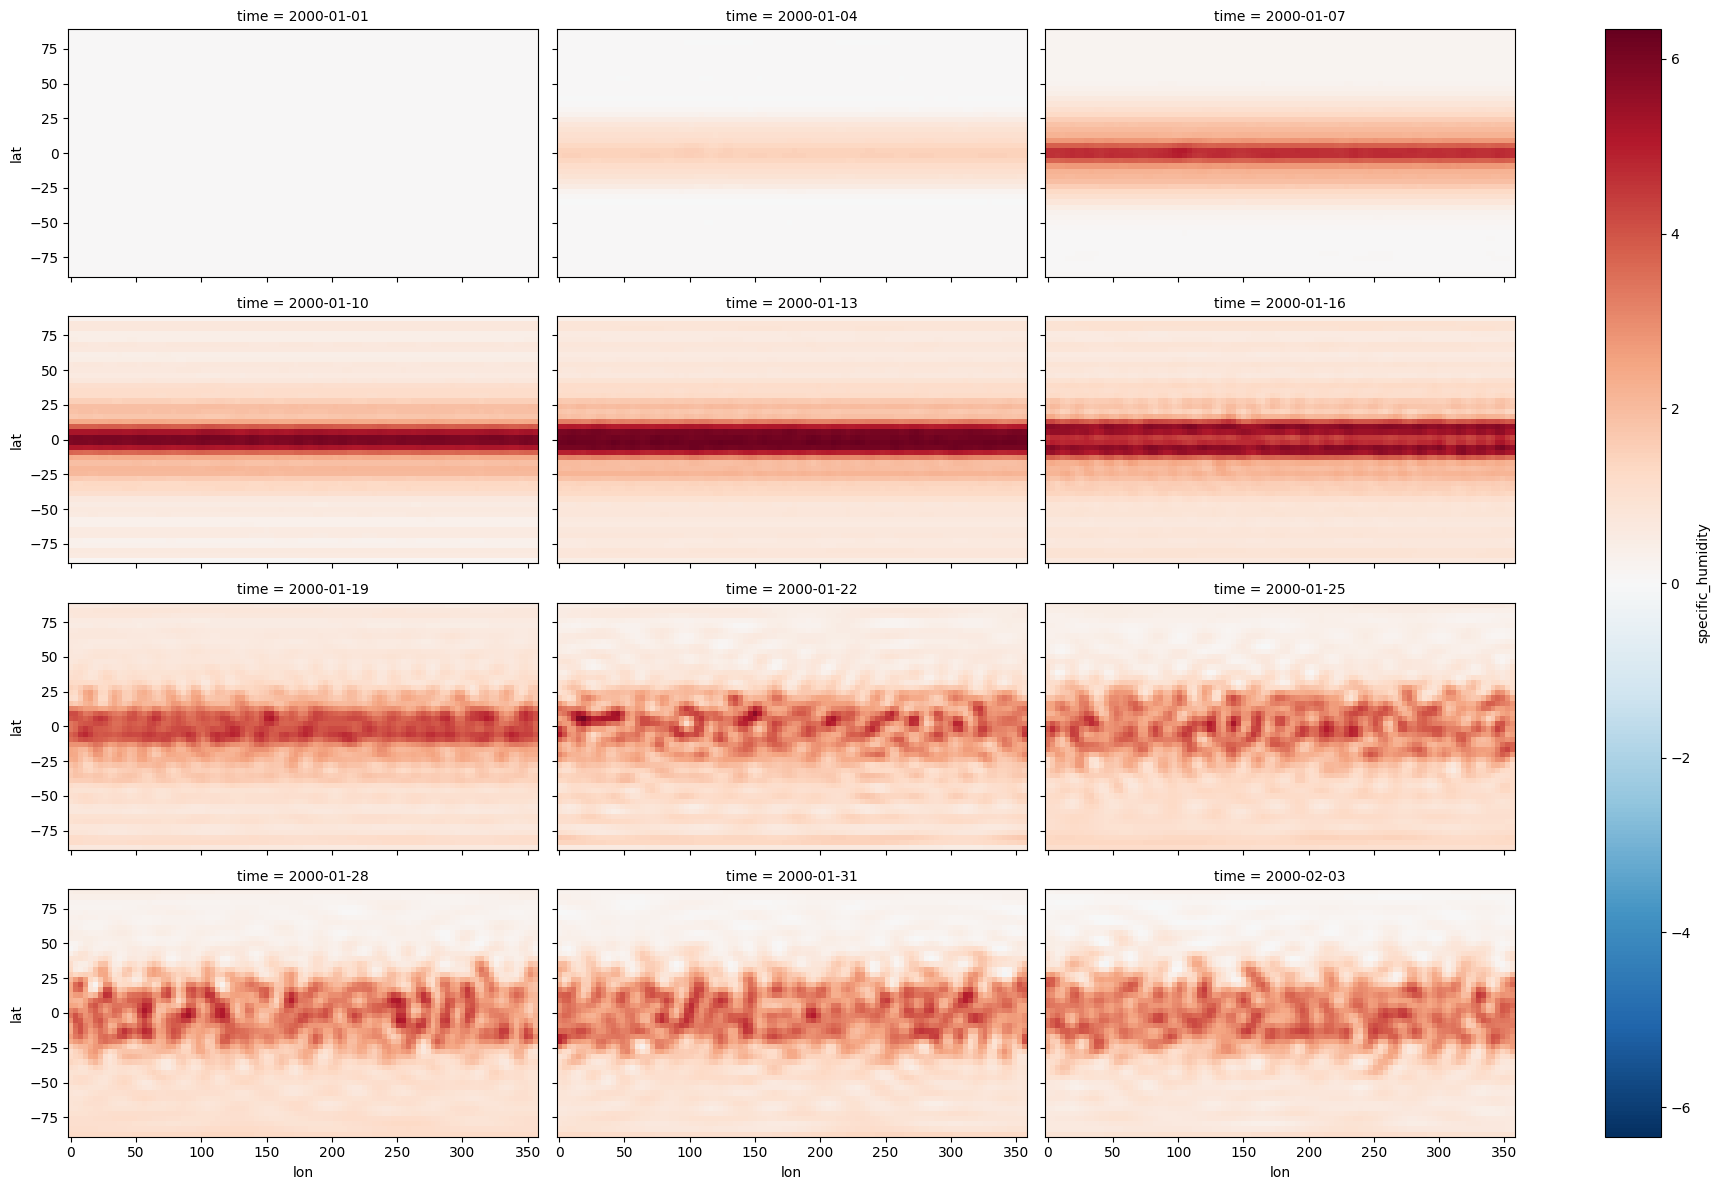

In [12]:
pred_ds['specific_humidity'].mean('lon').plot(x='lat', y='level', col='time', col_wrap=3, aspect=6, yincrease=False);
pred_ds['specific_humidity'].isel(level=3).plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2);

### clouds!

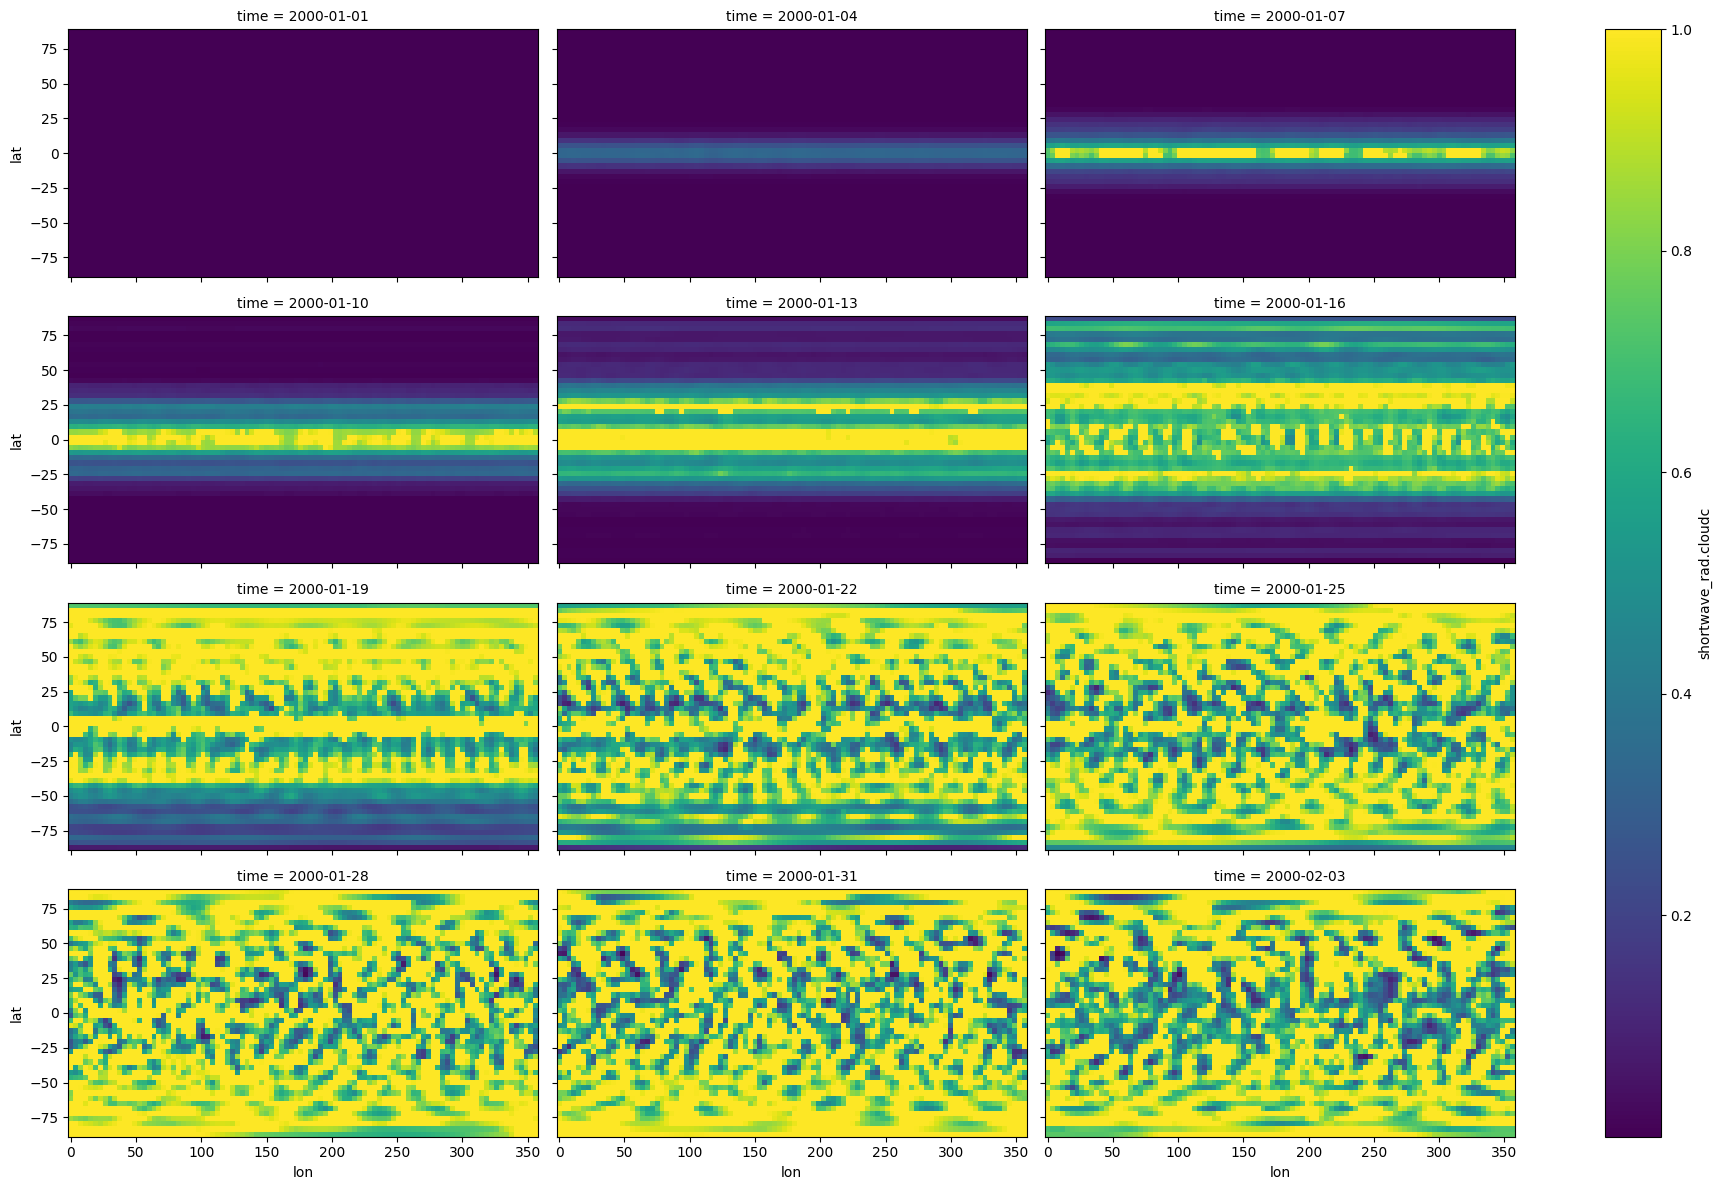

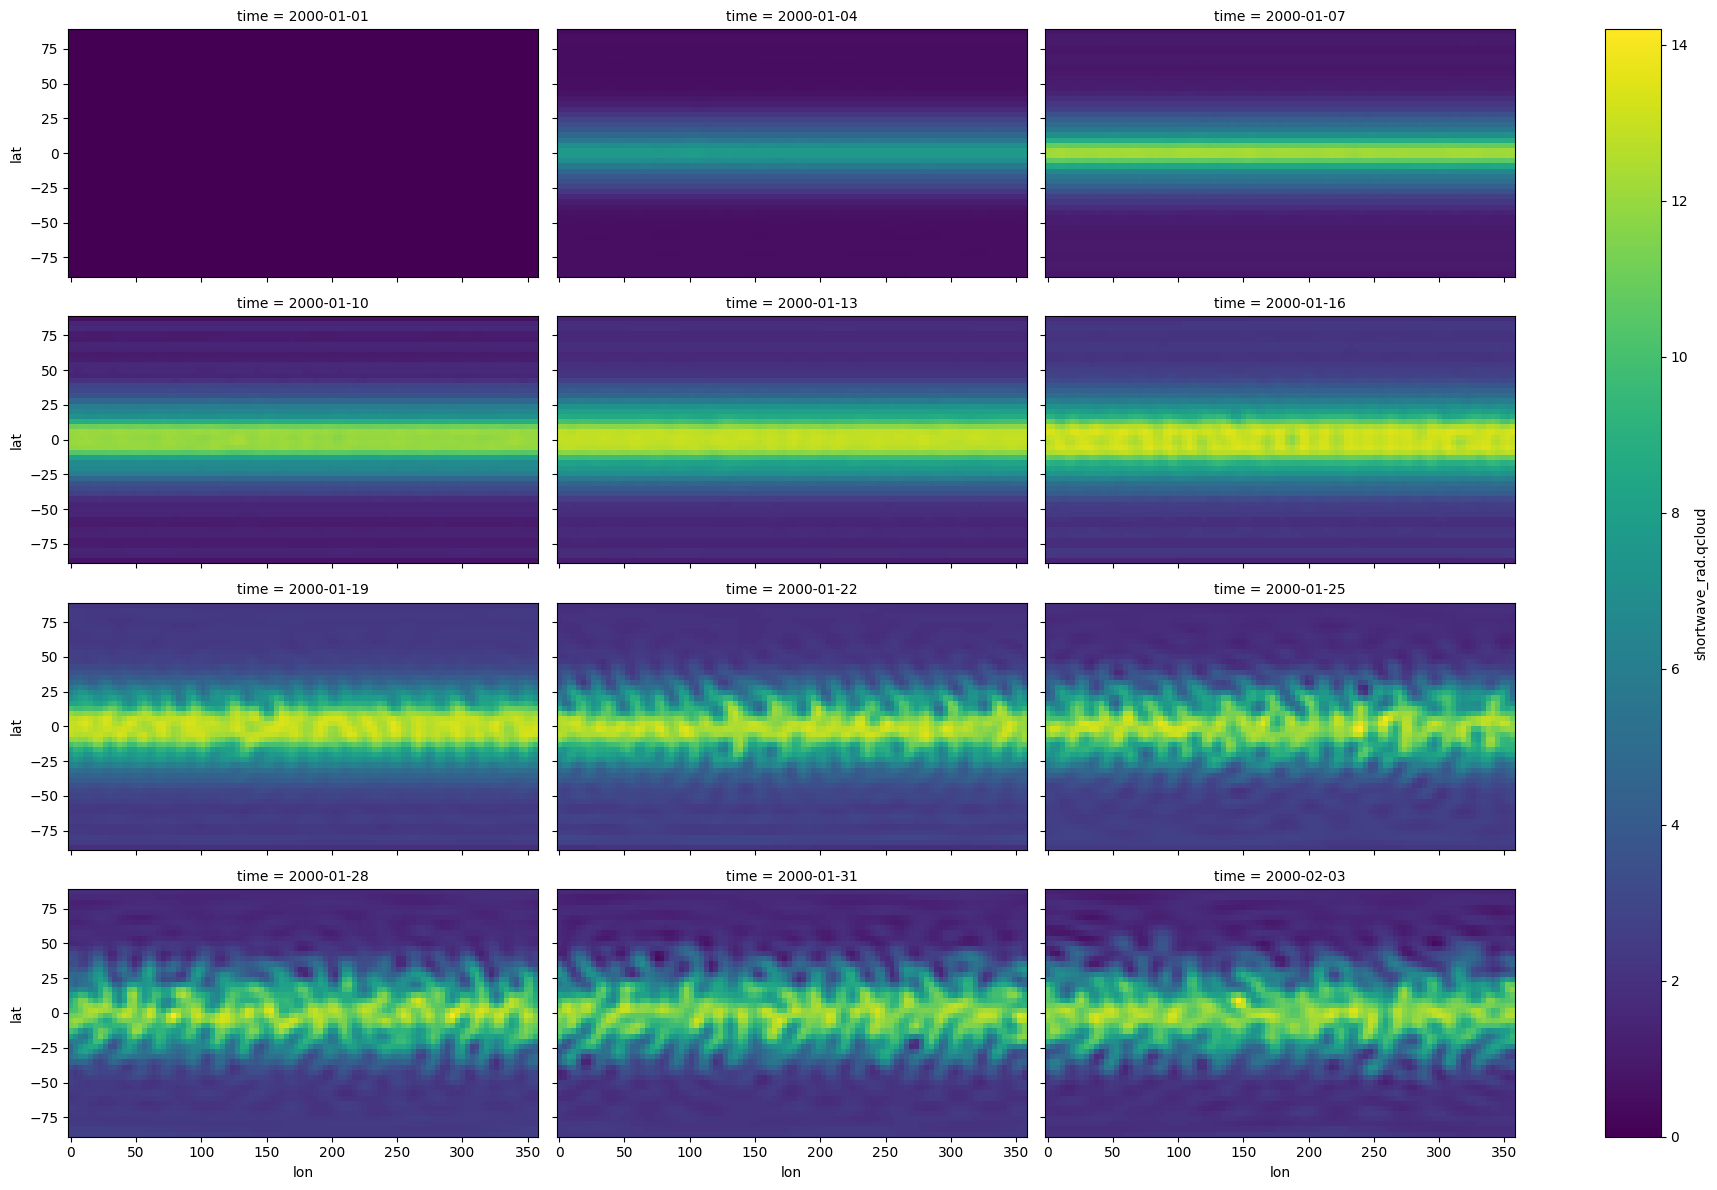

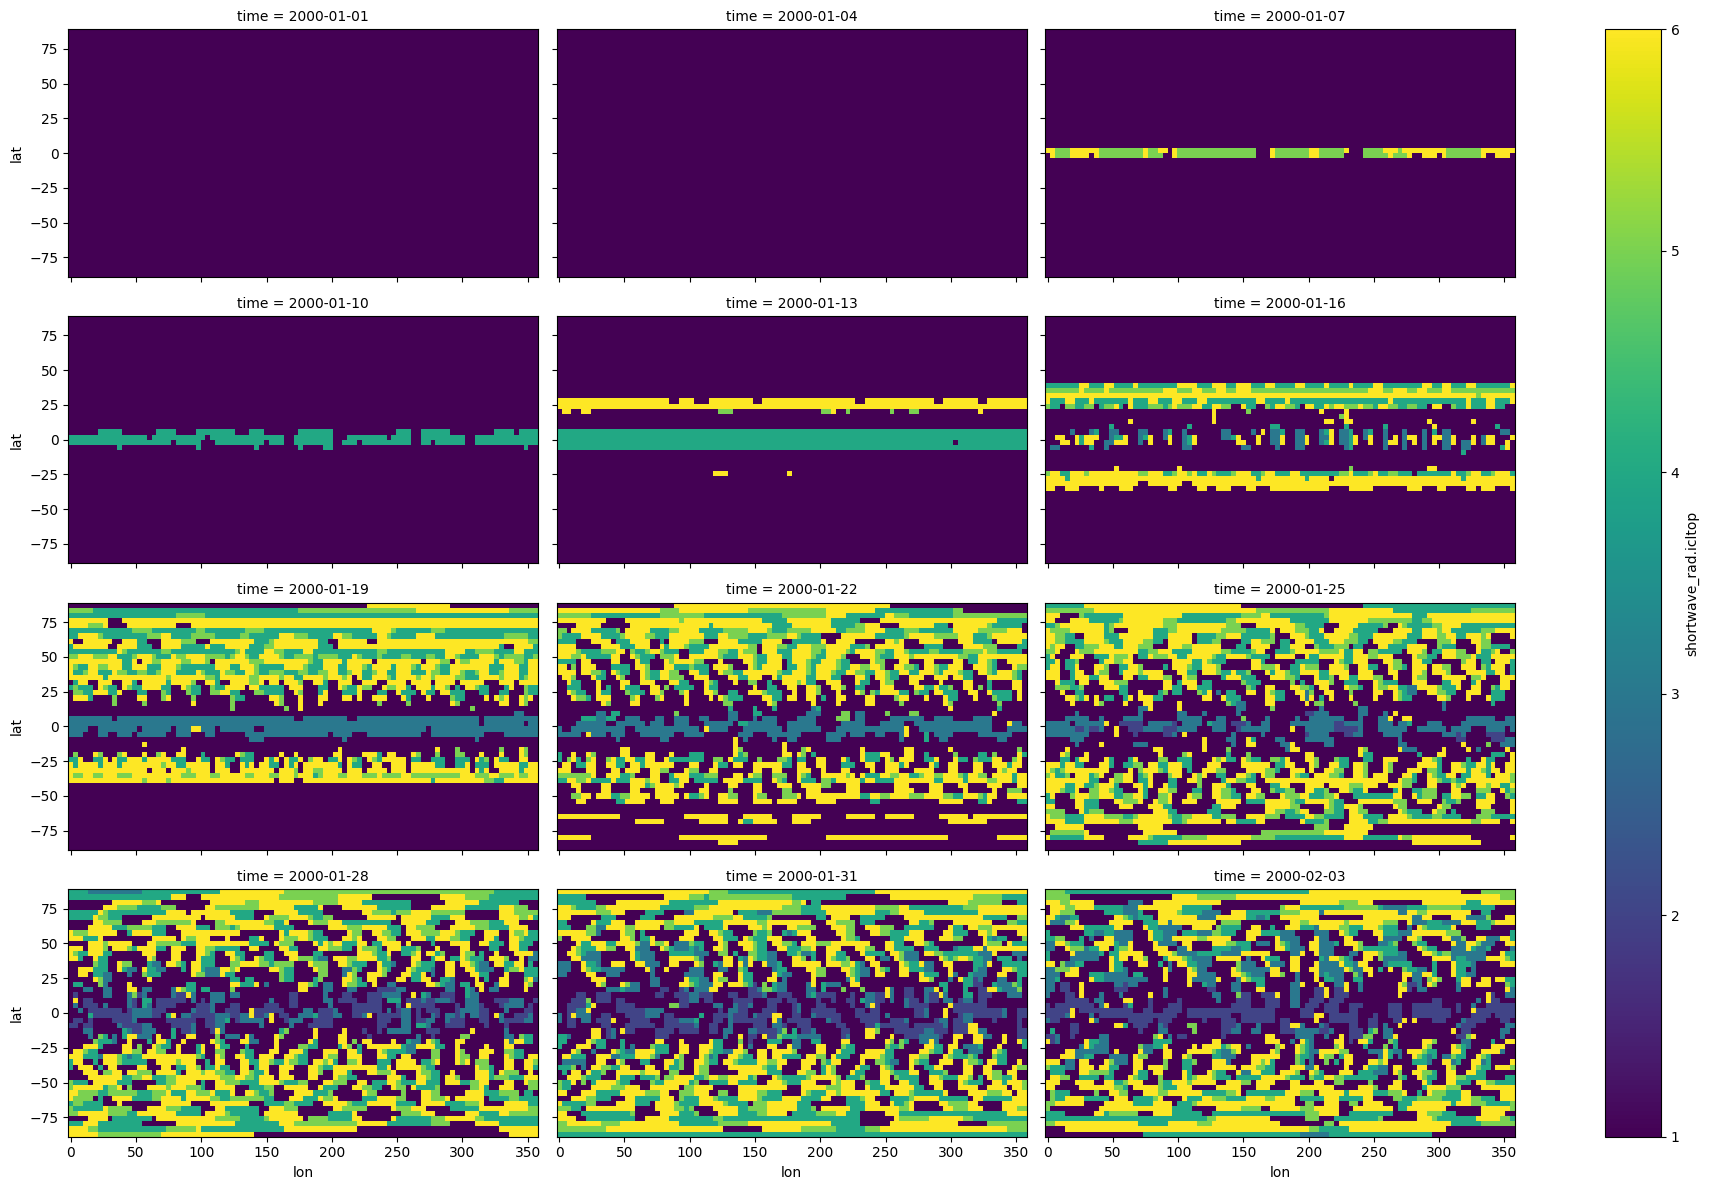

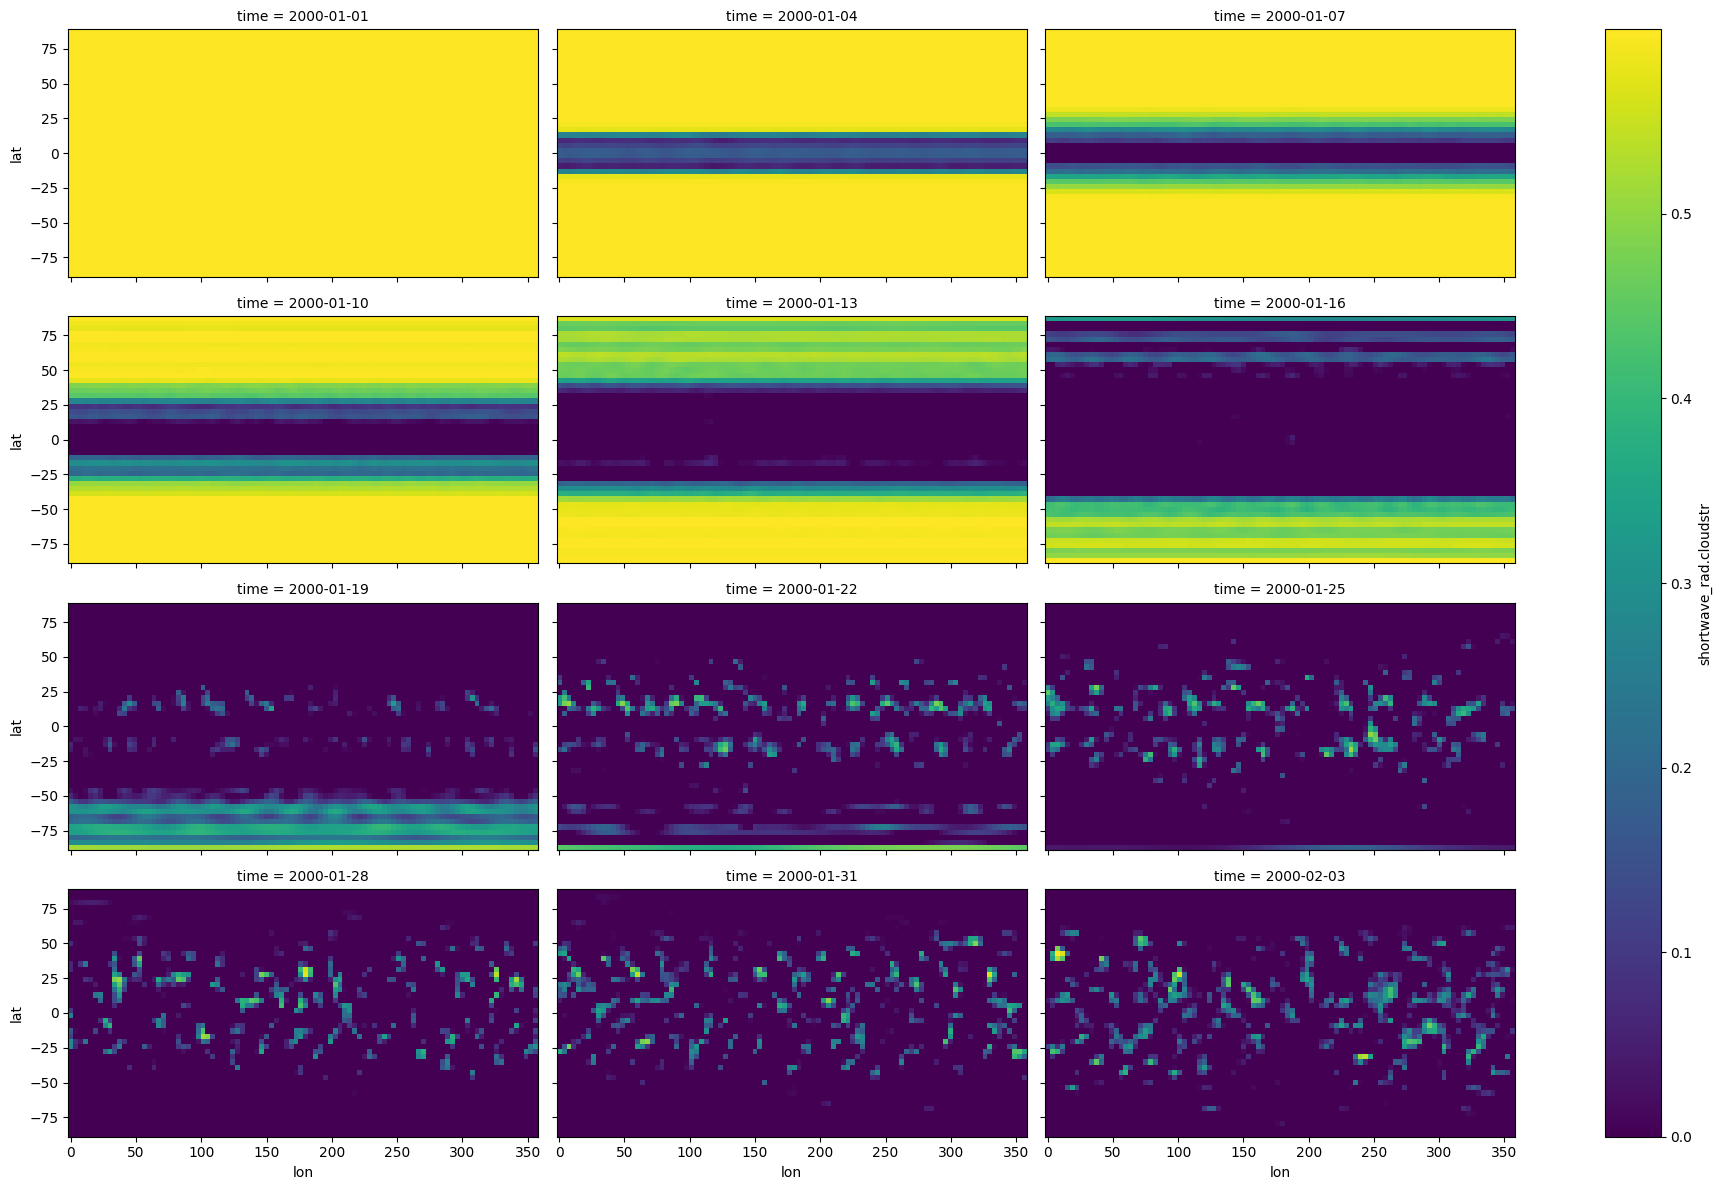

In [13]:
pred_ds['shortwave_rad.cloudc'].plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2);
pred_ds['shortwave_rad.qcloud'].plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2);
pred_ds['shortwave_rad.icltop'].plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2);
pred_ds['shortwave_rad.cloudstr'].plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2);